In [28]:
import os
import random
import stock_analysis
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
from trader_utils import *

def read_input_files(file_names):
    dfs = []
    for file_name in file_names:
        if os.path.exists(file_name):
            df = pd.read_csv(file_name)
            df['date'] = pd.to_datetime(df['date'])
            dfs.append(df)
        else:
            print(f"The input file {file_name} does not exit in the current folder.")
        merged_df = dfs[0]  # Start with the first DataFrame

        for df in dfs[1:]:
            # Perform an as-of merge with each subsequent DataFrame
            merged_df = pd.merge_asof(merged_df.sort_values('date'), df.sort_values('date'), on='date', direction='nearest') #, tolerance=pd.Timedelta('10 days')

        merged_df.set_index('date', drop=True, inplace=True)

    return merged_df

def plot_time_log(logs, file_name):

    fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 8))  # 5 rows, 1 column, shared x-axis

    # Plot closing price
    axs[0].plot(logs['time_step'], logs['close_price'], label='Close Price', color='tab:blue')
    axs[0].set_ylabel('Close Price')
    axs[0].legend(loc='upper left')
    axs[0].grid(True)

    # Plot number of shares
    axs[1].plot(logs['time_step'], logs['num_shares'], label='Number of Shares', color='tab:orange')
    axs[1].set_ylabel('Shares')
    axs[1].legend(loc='upper left')
    axs[1].grid(True)

    # Plot balance
    axs[2].plot(logs['time_step'], logs['balance'], label='Balance', color='tab:green')
    axs[2].set_ylabel('Balance')
    axs[2].legend(loc='upper left')
    axs[2].grid(True)

    # Plot portfolio
    portfolio = logs['balance'] + logs['num_shares'] * logs.at[len(logs)-1, 'close_price']
    axs[3].plot(logs['time_step'], portfolio, label='Portfolio', color='tab:green')
    axs[3].set_ylabel('Total Portfolio Value')
    axs[3].legend(loc='upper left')
    axs[3].grid(True)

    # Plot actions
    axs[4].step(logs['time_step'], logs['action'], label='Actions', color='tab:red', where='mid')
    axs[4].set_yticks([0, 1, 2])
    axs[4].set_yticklabels(['Sell', 'Hold', 'Buy'])
    axs[4].set_ylabel('Actions')
    axs[4].set_xlabel('Time Step')
    axs[4].legend(loc='upper left')
    axs[4].grid(True)

    plt.suptitle('Trading Log')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding to leave space for the suptitle
    fig.savefig(file_name)
    plt.show()

def plot_benchmark_log(logs_list, file_name):
    # Create a matplotlib color cycle for plotting multiple lines
    color_cycle = plt.cm.tab10.colors  # Default color cycle from matplotlib

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 8))  # 5 rows, 1 column, shared x-axis
    labels = ['DQN RL', 'RSI', 'CCI', 'Donchian', 'Return']
    linewidths = [3, 1, 1, 1, 1]

    # Plot closing price
    logs = logs_list[0]
    axs[0].plot(logs['time_step'], logs['close_price'], label='Close Price')
    axs[0].set_ylabel('Close Price')
    axs[0].legend(loc='upper left')
    axs[0].grid(True)

    # Iterate through each dictionary in the list
    for index, logs in enumerate(logs_list):
        color = color_cycle[index % len(color_cycle)]  # Cycle through colors

        # Plot number of shares
        axs[1].plot(logs['time_step'], logs['num_shares'], label=labels[index], color=color, linewidth=linewidths[index])
        axs[1].set_ylabel('Number of Shares')
        axs[1].legend(loc='upper left')
        axs[1].grid(True)

        # Plot portfolio value
        portfolio = logs['balance'] + logs['num_shares'] * logs['close_price']
        axs[2].plot(logs['time_step'], portfolio, label=labels[index], color=color, linewidth=linewidths[index])
        axs[2].set_ylabel('Total Portfolio Value')
        axs[2].legend(loc='upper left')
        axs[2].grid(True)

        # Plot actions
        axs[3].step(logs['time_step'], logs['action'], label=labels[index], color=color, where='mid', linewidth=linewidths[index])
        axs[3].set_yticks([0, 1, 2])
        axs[3].set_yticklabels(['Sell', 'Hold', 'Buy'])
        axs[3].set_ylabel('Actions')
        axs[3].set_xlabel('Time Step')
        axs[3].legend(loc='upper left')
        axs[3].grid(True)

    plt.suptitle('Trading Log')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding to leave space for the suptitle
    fig.savefig(file_name)
    plt.show()

def train_agent(env, agent, n_ep, batch_size, reset_pr):
    rewards_stds = []
    rewards_means = []
    agent.epsilon_decay = (agent.epsilon_f/agent.epsilon_i)**(1/n_ep)
    for e in range(n_ep):
        state_size = env.observation_space.shape[0]
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            random_reset = (np.random.rand() < reset_pr)
            if random_reset:
                break
            state = next_state
            if done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        
        rewards_log = env.get_rewards_log()
        rewards_mean = np.mean(rewards_log)
        rewards_std= np.std(rewards_log)
        rewards_means.append(rewards_mean)
        rewards_stds.append(rewards_std)
        print(f"Episode: {e}\t Rewards Mean: {rewards_mean:.2f}\t Rewards STD: {rewards_std:.2f}\t Epsilon: {agent.epsilon:.2f}")
        if agent.epsilon > agent.epsilon_f:
            agent.epsilon *= agent.epsilon_decay
        
        # Update plot for every episode
        if e % 1 == 0:  # You can change the number to update after more episodes
            clear_output(wait=True)
            fig, ax = plt.subplots()
            # smooth_window = max(int(e/100), 1)  # Avoid zero window size
            ax.errorbar(range(len(rewards_means)), rewards_means, yerr=rewards_stds, ecolor='gray')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Rewards Mean')
            ax.set_title('Rewards Mean and STD of each Episode')
            plt.show()

    # Save the final plot
    fig.savefig('train_portfolio_vs_ep.pdf')
    return agent

def test_agent(agent, env):
    state_size = env.observation_space.shape[0]
    agent.epsilon = 0
    agent.learning_rate = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    logs = []
    while not done:  # or env.spec.max_episode_steps
        # print("\033[A\033[K", end="")
        # print(f"Time step: {time_step}") 
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        # env.render()
    logs.append(env.get_logs())
    
    benchmark_agents = [RSIAgent(), CCIAgent(), DonchianAgent(), ReturnAgent()]
    for signal_agent in benchmark_agents:
        state = env.reset()
        done = False
        while not done:  # or env.spec.max_episode_steps
            # print("\033[A\033[K", end="")
            # print(f"Time step: {time_step}") 
            action = signal_agent.act(state)
            next_state, _, done, _ = env.step(action)
            state = next_state
        logs.append(env.get_logs())

    # logs = env.get_logs() 
    plot_time_log(logs[0], file_name='test_log.pdf')
    plot_benchmark_log(logs, 'benchmark_log.pdf')

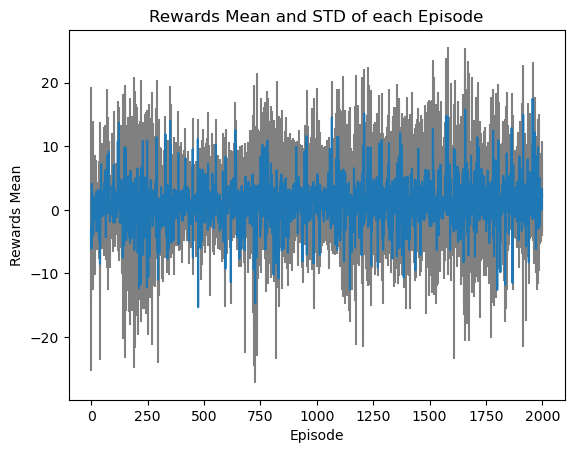

In [10]:
# Read input data
file_names = ['spy_price_signals.csv']
data = read_input_files(file_names)
data.sort_values(by='date', ascending=True, inplace=True)

##################### Training phase #####################

# Trainer environment setup
dates = ['2022-01', '2023-01']
signal_types = ['rsi_sig', 'cci_sig', 'donchian_sig', 'return_sig']
train_signal_data = (
    data[(data.index >= dates[0]) & (data.index < dates[1])]
    .loc[:, signal_types]
    .reset_index(drop=True)
)

train_price_data = (
    data[(data.index >= dates[0]) & (data.index < dates[1])]
    .loc[:, ['close', 'open']]
    .reset_index(drop=True)
)
env = StockTradingEnv(train_price_data, train_signal_data, initial_balance=10000, initial_share=10, random_start=True)

# Agent setup
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
agent = DQNAgent(state_size, action_size)
# load_agent_state(filename='agent_checkpoint.pth')

# Train the agent
agent = train_agent(env, agent, n_ep=2000, batch_size=32, reset_pr=0.01)
save_agent_state(agent)

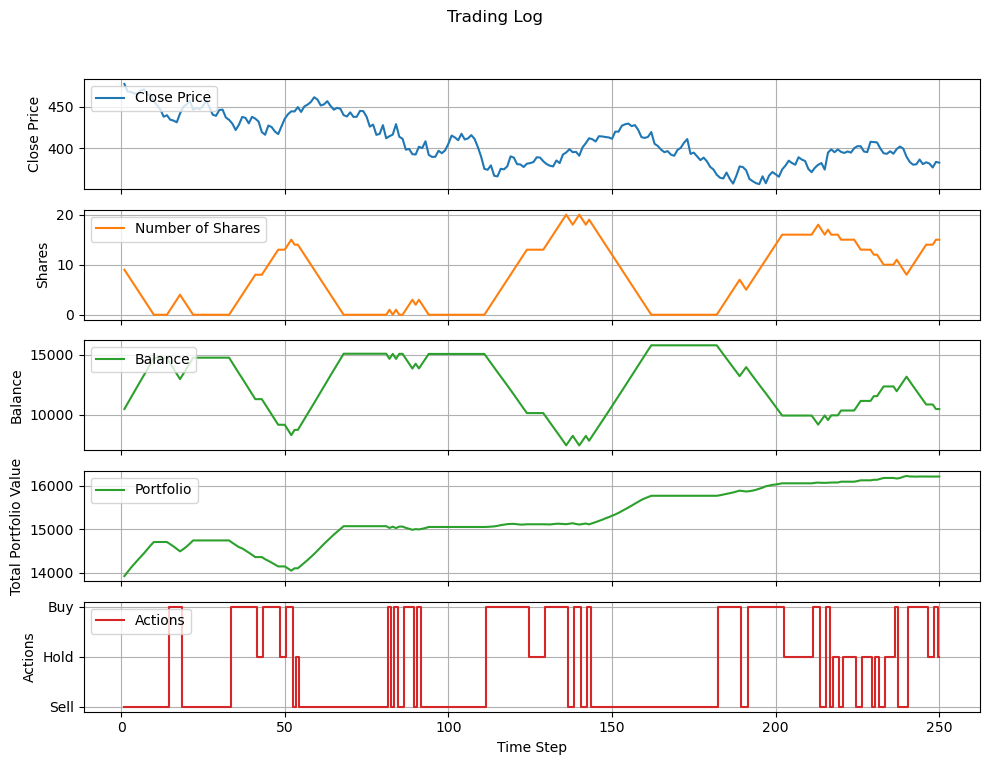

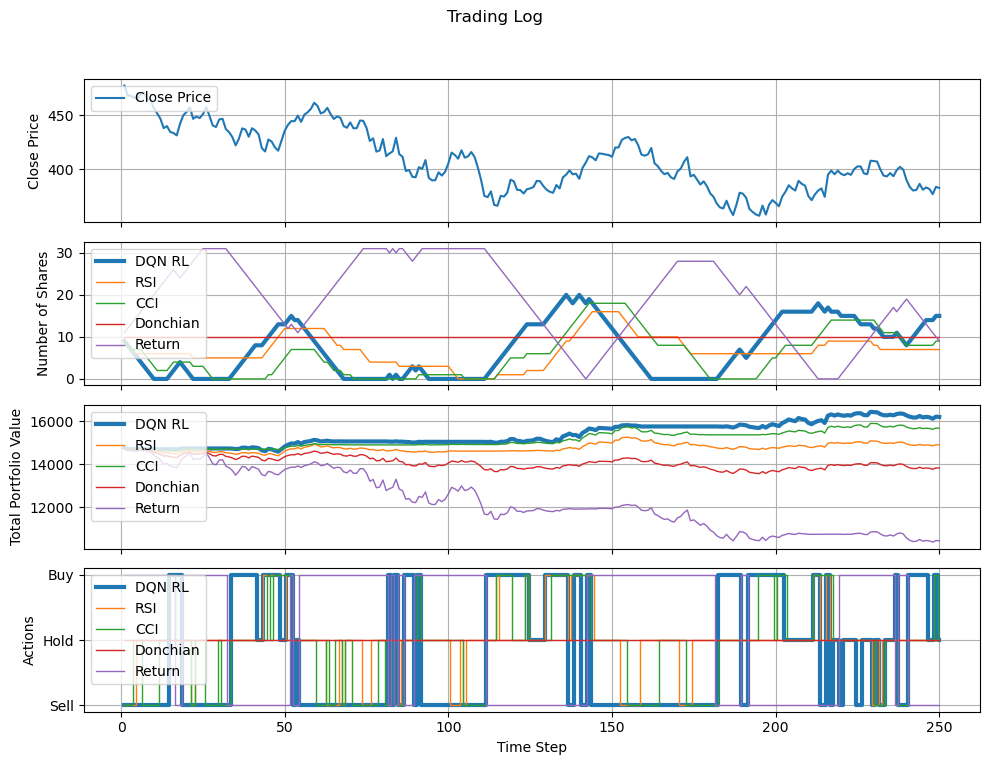

In [29]:
##################### Testing phase #####################

# Test environment setup
data.sort_values(by='date', ascending=True, inplace=True)
dates = ['2022-01', '2023-01']
test_signal_data = (
    data[(data.index >= dates[0]) & (data.index < dates[1])]
    .loc[:, signal_types]
    .reset_index(drop=True)
)
test_price_data = (
    data[(data.index >= dates[0]) & (data.index < dates[1])]
    .loc[:, ['close', 'open']]
    .reset_index(drop=True)
)
env = StockTradingEnv(test_price_data, test_signal_data, initial_balance=10000, initial_share=10, random_start=False)

test_agent(agent, env)